# Benchmarking Audioseal on RAVDESS Dataset in Different Audio Formats

In this notebook, we outline the steps taken to benchmark the Audioseal architecture against different attacks on a dataset of audio files, including evaluations in different audio formats (AAC at 64 kbps and Original Bit Depth (OBD)).  
In particular, we follow these steps:
- Load audio files from a dataset
- Convert the audio files into different formats (AAC 64 kbps and OBD)
- Watermark each audio file using Audioseal
- Perform perturbations/attacks to the audio files
- Detect the watermarks on these attacked files and keep track of the confidence of Audioseal in its predictions that the files are watermarked.

For a better understanding of Audioseal and its functionalities, it is highly recommended to go through the [Getting started notebook](https://github.com/facebookresearch/audioseal/blob/main/examples/Getting_started.ipynb).

## Dataset

We will use the [RAVDESS Emotional Speech audio](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio) dataset for this experiment.
To download the dataset from Kaggle, ensure that you have your `kaggle.json` file ready, which contains your Kaggle API credentials.
- Go to your Kaggle account, navigate to the API section, and click on "Create New API Token". This will download a `kaggle.json` file.
- Upload this file in the code below for authentication, and the dataset will be downloaded automatically.

In [1]:
!pip install kaggle

Go to Kaggle & navigate to your Account settings by clicking on your profile picture.

Under the API section, click on Create New API Token. This will download a kaggle.json file containing your API credentials.

Upload the kaggle.json file to your Colab notebook:

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hastagab","key":"0a8af41bf3c7b0e3ba63fc55d3807c7f"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!pip install torchaudio
!pip install ffmpeg-python
!pip install audioseal

## Step 1: Download the Dataset

In [7]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!unzip ravdess-emotional-speech-audio.zip -d ./ravdess_audio_dataset

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
... resuming from 1048576 bytes (449054314 bytes left) ...
100% 429M/429M [00:21<00:00, 21.7MB/s]
100% 429M/429M [00:21<00:00, 21.3MB/s]
Archive:  ravdess-emotional-speech-audio.zip
  inflating: ./ravdess_audio_dataset/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ./ravdess_audio_dataset/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ./ravdess_audio_dataset/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ./ravdess_audio_dataset/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ./ravdess_audio_dataset/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ./ravdess_audio_dataset/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ./ravdess_audio_dataset/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ./ravdess_audio_dataset/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ./ravdess_audio_dataset/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ./ravdess_audio_dataset/Actor_01

In [8]:
import numpy as np
import pandas as pd
import os

all_input_files = []
PARENT_FILES_DIR = './ravdess_audio_dataset'

for dirname, _, filenames in os.walk(PARENT_FILES_DIR):
    for filename in filenames:
        if filename.endswith(".wav"):
            all_input_files.append(os.path.join(dirname, filename))

print(f"Number of input files: {len(all_input_files)}")

Number of input files: 2880


### Installations and Imports

In [1]:
import sys
!{sys.executable} -m pip install -q soundfile matplotlib audioseal
!pip install torchaudio

import typing as tp
import julius
import torch
import torchaudio
import urllib

## Step 2: Convert Audio Files to Different Formats (AAC 64 kbps and OBD)

In this step, we convert the audio files to AAC format at 64 kbps and keep the original bit depth (OBD) files for comparison.

In [9]:
import subprocess

def convert_audio(input_file, output_format, bitrate=None):
    output_file = f"{os.path.splitext(input_file)[0]}_{output_format}.{output_format}"
    if output_format == "aac":
        bitrate_str = f"-b:a {bitrate}" if bitrate else ""
        subprocess.call(f"ffmpeg -i {input_file} -c:a aac {bitrate_str} {output_file}", shell=True)
    return output_file

In [10]:
# Convert all files to AAC 64 kbps
converted_aac_files = []
for input_file in all_input_files:
    converted_file = convert_audio(input_file, "aac", "64k")
    converted_aac_files.append(converted_file)

print(f"Number of AAC 64 kbps files: {len(converted_aac_files)}")

Number of AAC 64 kbps files: 2880


## Step 3: Watermarking the Audio Files

In [11]:
from audioseal import AudioSeal
import torchaudio

watermarked_files = []

generator = AudioSeal.load_generator("audioseal_wm_16bits")

# secret message for watermarking
secret_message = torch.randint(0, 2, (1, 16), dtype=torch.int32)

import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
secret_message = secret_message.to(device)

watermarked_files = []

for input_file in all_input_files:
    waveform, sample_rate = torchaudio.load(input_file)

    # Convert stereo to mono if needed
    if waveform.size(0) > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    waveform = waveform.to(device)

    watermarked_waveform = generator(waveform.unsqueeze(0), sample_rate=sample_rate, message=secret_message, alpha=1.0)
    watermarked_waveform = watermarked_waveform.squeeze(0)

    output_path = f"{os.path.splitext(input_file)[0]}_watermarked.wav"
    torchaudio.save(output_path, watermarked_waveform.cpu(), sample_rate)

    watermarked_files.append(output_path)

    del waveform, watermarked_waveform
    torch.cuda.empty_cache()

print("Watermarking completed for original WAV files.")

Downloading: "https://huggingface.co/facebook/audioseal/resolve/main/generator_base.pth" to /root/.cache/audioseal/0f195d476dd87ca1bd7b09e6
100%|██████████| 56.1M/56.1M [00:01<00:00, 41.5MB/s]


Watermarking completed for original WAV files.


## Step 4: Performing Attacks and Evaluating AudioSeal in Different Formats


In [12]:
import matplotlib.pyplot as plt
import torch

detector = AudioSeal.load_detector("audioseal_detector_16bits")

print("Evaluating AAC 64 kbps audio files...")
for aac_file in converted_aac_files:
    waveform, sample_rate = torchaudio.load(aac_file)

    if waveform.size(0) > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    waveform = waveform.unsqueeze(0)

    detection_result, confidence = detector.detect_watermark(waveform, sample_rate=sample_rate)

    mean_confidence = confidence.float().mean().item()

    print(f"Detection result for AAC 64 kbps ({os.path.basename(aac_file)}): {detection_result}, Mean Confidence: {mean_confidence:.4f}")

    # Visualize the AAC audio, if needed [This will increase the notebook size]
    # plt.figure(figsize=(10, 4))
    # plt.plot(waveform[0][0].numpy(), label='AAC 64 kbps')  # Plotting first channel
    # plt.title(f'AAC 64 kbps Audio: {os.path.basename(aac_file)}')
    # plt.xlabel('Sample Index')
    # plt.ylabel('Amplitude')
    # plt.legend()
    # plt.show()


Downloading: "https://huggingface.co/facebook/audioseal/resolve/main/detector_base.pth" to /root/.cache/audioseal/94c8df0b1d5ea8e45af4c884
100%|██████████| 33.1M/33.1M [00:00<00:00, 41.7MB/s]


Evaluating AAC 64 kbps audio files...
Detection result for AAC 64 kbps (03-01-05-02-02-01-17_aac.aac): 0.0, Mean Confidence: 0.5000
Detection result for AAC 64 kbps (03-01-06-01-02-01-17_aac.aac): 0.0, Mean Confidence: 0.5000
Detection result for AAC 64 kbps (03-01-02-02-02-01-17_aac.aac): 0.0, Mean Confidence: 0.3125
Detection result for AAC 64 kbps (03-01-07-01-01-01-17_aac.aac): 0.0, Mean Confidence: 0.5000
Detection result for AAC 64 kbps (03-01-06-01-01-01-17_aac.aac): 0.0, Mean Confidence: 0.5000
Detection result for AAC 64 kbps (03-01-06-01-01-02-17_aac.aac): 0.0, Mean Confidence: 0.5625
Detection result for AAC 64 kbps (03-01-03-02-02-01-17_aac.aac): 0.0, Mean Confidence: 0.4375
Detection result for AAC 64 kbps (03-01-06-01-02-02-17_aac.aac): 0.0, Mean Confidence: 0.5000
Detection result for AAC 64 kbps (03-01-05-01-02-01-17_aac.aac): 0.0, Mean Confidence: 0.5000
Detection result for AAC 64 kbps (03-01-05-02-01-02-17_aac.aac): 0.0, Mean Confidence: 0.6875
Detection result for A

In [13]:
import matplotlib.pyplot as plt
import torch

detector = AudioSeal.load_detector("audioseal_detector_16bits")

print("Evaluating Original Bit Depth (OBD) audio files...")
for original_file in watermarked_files:
    waveform, sample_rate = torchaudio.load(original_file)

    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    waveform = waveform.unsqueeze(0)

    detection_result, confidence = detector.detect_watermark(waveform, sample_rate=sample_rate)

    if confidence.numel() > 1:
        mean_confidence = confidence.float().mean().item()
    else:
        mean_confidence = confidence.item()

    print(f"Detection result for OBD ({os.path.basename(original_file)}): {detection_result}, Mean Confidence: {mean_confidence:.4f}")

    # Visualize the OBD audio, if needed
    # plt.figure(figsize=(10, 4))
    # plt.plot(waveform[0][0].detach().numpy(), label='OBD')
    # plt.title(f'OBD Audio: {os.path.basename(original_file)}')
    # plt.xlabel('Sample Index')
    # plt.ylabel('Amplitude')
    # plt.legend()
    # plt.show()

Evaluating Original Bit Depth (OBD) audio files...
Detection result for OBD (03-01-05-02-02-01-17_watermarked.wav): 1.0, Mean Confidence: 0.5625
Detection result for OBD (03-01-06-01-02-01-17_watermarked.wav): 1.0, Mean Confidence: 0.5625
Detection result for OBD (03-01-02-02-02-01-17_watermarked.wav): 1.0, Mean Confidence: 0.5625
Detection result for OBD (03-01-07-01-01-01-17_watermarked.wav): 1.0, Mean Confidence: 0.5625
Detection result for OBD (03-01-06-01-01-01-17_watermarked.wav): 1.0, Mean Confidence: 0.5625
Detection result for OBD (03-01-06-01-01-02-17_watermarked.wav): 1.0, Mean Confidence: 0.5625
Detection result for OBD (03-01-03-02-02-01-17_watermarked.wav): 1.0, Mean Confidence: 0.5625
Detection result for OBD (03-01-06-01-02-02-17_watermarked.wav): 1.0, Mean Confidence: 0.5625
Detection result for OBD (03-01-05-01-02-01-17_watermarked.wav): 1.0, Mean Confidence: 0.5625
Detection result for OBD (03-01-05-02-01-02-17_watermarked.wav): 1.0, Mean Confidence: 0.5625
Detection

## Step 5: Summary of Results

In [14]:
results = {
    "AAC 64 kbps": [],
    "OBD": []
}

for aac_file in converted_aac_files:
    waveform, sample_rate = torchaudio.load(aac_file)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    waveform = waveform.unsqueeze(0)
    detection_result, confidence = detector.detect_watermark(waveform, sample_rate=sample_rate)
    results["AAC 64 kbps"].append(confidence)

for original_file in watermarked_files:
    waveform, sample_rate = torchaudio.load(original_file)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    waveform = waveform.unsqueeze(0)
    detection_result, confidence = detector.detect_watermark(waveform, sample_rate=sample_rate)
    results["OBD"].append(confidence)

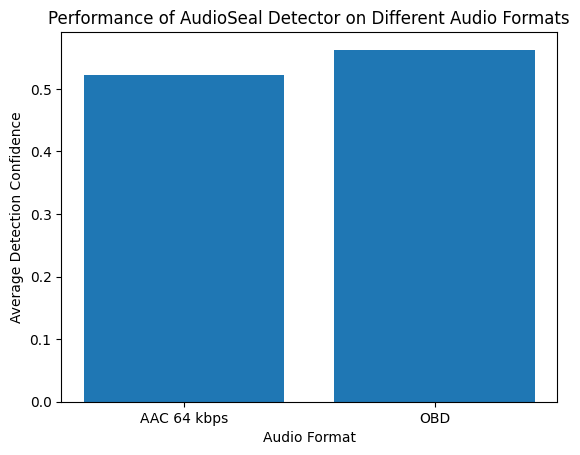

In [15]:
labels = list(results.keys())
average_confidences = [np.mean(results[label]) for label in labels]

plt.bar(labels, average_confidences)
plt.xlabel('Audio Format')
plt.ylabel('Average Detection Confidence')
plt.title('Performance of AudioSeal Detector on Different Audio Formats')
plt.show()